In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config=ConfigProto()
config.gpu_options.allow_growth=True
session=InteractiveSession(config=config)


from keras.layers import Conv2D, AveragePooling2D, concatenate,Dense
from keras.models import Model
from keras import Input
image_input=Input(shape=(300,300,3))
branch_a=Conv2D(64,1,activation='relu',strides=2)(image_input)
branch_b=Conv2D(64,1,activation='relu')(image_input)
branch_b=Conv2D(64,3, activation='relu',padding='same',strides=2)(branch_b)
branch_c=AveragePooling2D(2)(image_input)
branch_c=Conv2D(64,3,activation='relu',padding='same')(branch_c)
branch_d=Conv2D(64,5,activation='relu',padding='same')(image_input)
branch_d=Conv2D(64,3,activation='relu',padding='same')(branch_d)
branch_d=Conv2D(64,3,activation='relu',padding='same',strides=2)(branch_d)
concatenated=concatenate([branch_a,branch_b,branch_c,branch_d],axis=-1)
out=Dense(1, activation='sigmoid')(concatenated)
model=Model(image_input,out)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 300, 300, 64) 4864        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 300, 300, 64) 256         input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 150, 150, 3)  0           input_1[0][0]                    
____________________

Using TensorFlow backend.


In [2]:
#!pip install scikit-image
import pandas as pd 
from skimage import io
data=pd.read_csv('C:/Users/ysp/Desktop/Deep Learning/a943287.csv')

data_male=data[data['please_select_the_gender_of_the_person_in_the_picture']=='male']
data_female=data[data['please_select_the_gender_of_the_person_in_the_picture']=='female']
final_data=pd.concat([data_male[:1000],data_female[:1000]], axis=0).reset_index(drop=True)

x_p=[]
y_p=[]
for i in range(final_data.shape[0]):
    try:
        image=io.imread(final_data.loc[i]['image_url'])
        if (image.shape==(300,300,3)):
            x_p.append(image)
            y_p.append(final_data.loc[i]['please_select_the_gender_of_the_person_in_the_picture'])
    except:
        continue

In [3]:
import numpy as np
x1=[]
y1=[]
for i in range(len(x_p)):
    x1.append(x_p[i])
    img_label=np.where(y_p[i]=='male',1,0)
    y1.append(img_label)
#x1=np.array(x)
x=np.array(x1)
print(x.dtype)
y=np.array(y1)
print(np.unique(y))
print(x.shape)

uint8
[0 1]
(1740, 300, 300, 3)


In [4]:
#!pip install sklearn
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import preprocess_input
incep_model=inception_v3.InceptionV3(include_top=False, weights='imagenet',input_shape=(300,300,3))

x2=[]
for i in range(len(x)):
    img=x[i]
    img=preprocess_input(img.reshape(1,300,300,3))
    img_new=incep_model.predict(img.reshape(1,300,300,3))
    x2.append(img_new)
x2=np.array(x2)/255.
print(x2.shape, np.max(x2))
x2=x2.reshape(x2.shape[0],x2.shape[2], x2.shape[3], x2.shape[4])

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x2, y, test_size=0.15, random_state=42)
print(x_train.shape,np.max(x_train))
print(x_test.shape)
print(y_train.shape)
#x_train=x_train/np.max(x_train)
#x_test=x_test/np.max(x_train)

(1740, 1, 8, 8, 2048) 0.15837292
(1479, 8, 8, 2048) 0.15837292
(261, 8, 8, 2048)
(1479,)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
model_v3=Sequential()
model_v3.add(Conv2D(512,3,activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])))
model_v3.add(Flatten())
model_v3.add(Dense(512,activation='relu'))
model_v3.add(Dropout(0.7))
model_v3.add(Dense(1,activation='sigmoid'))
model_v3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 6, 6, 512)         9437696   
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 18,875,905
Trainable params: 18,875,905
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_v3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
history_v3=model_v3.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test))

Train on 1479 samples, validate on 261 samples
Epoch 1/15
1479/1479 [==============================] - 2s 1ms/sample - loss: 0.3218 - acc: 0.8452 - val_loss: 0.3172 - val_acc: 0.8659
Epoch 2/15
1479/1479 [==============================] - 1s 876us/sample - loss: 0.1769 - acc: 0.9277 - val_loss: 0.3115 - val_acc: 0.8851
Epoch 3/15
1479/1479 [==============================] - 1s 880us/sample - loss: 0.1193 - acc: 0.9581 - val_loss: 0.2936 - val_acc: 0.8812
Epoch 4/15
1479/1479 [==============================] - 1s 876us/sample - loss: 0.0895 - acc: 0.9696 - val_loss: 0.3440 - val_acc: 0.9080
Epoch 5/15
1479/1479 [==============================] - 1s 880us/sample - loss: 0.0565 - acc: 0.9757 - val_loss: 0.5060 - val_acc: 0.8582
Epoch 6/15
1479/1479 [==============================] - 1s 889us/sample - loss: 0.0475 - acc: 0.9878 - val_loss: 0.5673 - val_acc: 0.8697
Epoch 7/15
1479/1479 [==============================] - 1s 890us/sample - loss: 0.0298 - acc: 0.9905 - val_loss: 0.5004 - val_a

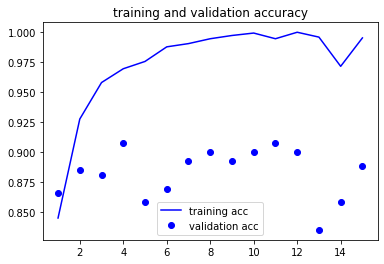

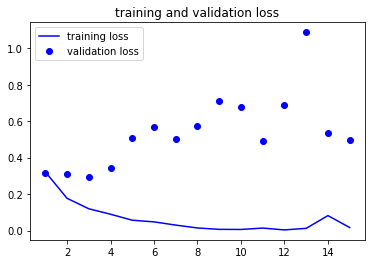

In [16]:
import matplotlib.pyplot as plt
acc=history_v3.history['acc']
val_acc=history_v3.history['val_acc']
loss=history_v3.history['loss']
val_loss=history_v3.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [13]:
from keras.models import Sequential
from keras.layers import SeparableConv2D, GlobalAveragePooling2D,Dense
model=Sequential()
model.add(SeparableConv2D(32,3,activation='relu',input_shape=(128,128,3)))
model.add(SeparableConv2D(64,5,activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(32,activation='relu'))
model.add(Dense(5,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 126, 126, 32)      155       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 122, 122, 64)      2912      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 5,312
Trainable params: 5,312
Non-trainable params: 0
_________________________________________________________________


Using TensorFlow backend.
